This code categorizes the websites and apps tracked by patterns

What is the plan?

1. Upload the survey data and the json data together in this file
2. Count c

In [1]:
#Run this if you don't have nbimporter installed yet

#pip3 install ipynb

In [2]:
import sys
sys.prefix != sys.base_prefix

True

/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


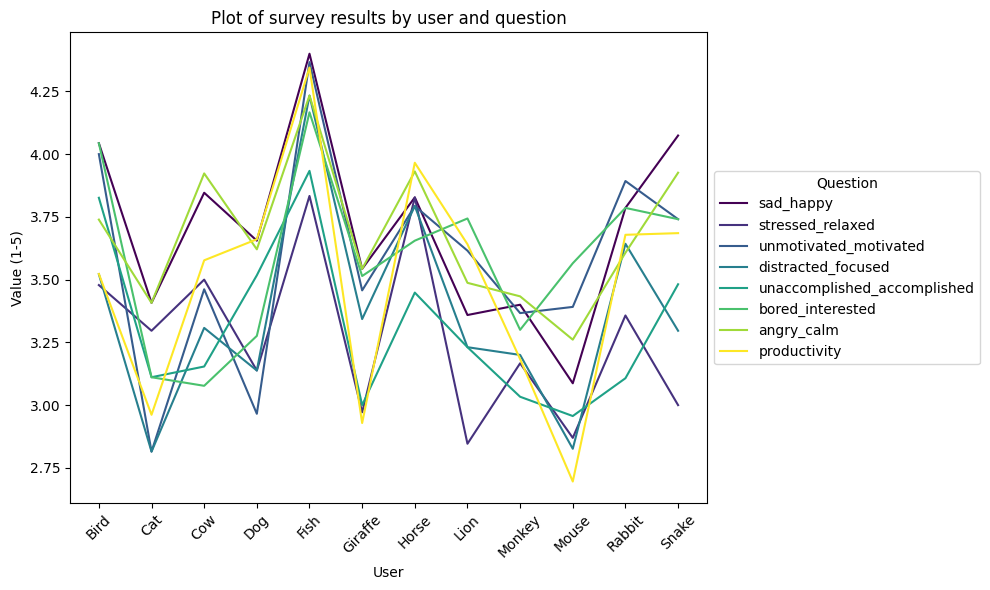

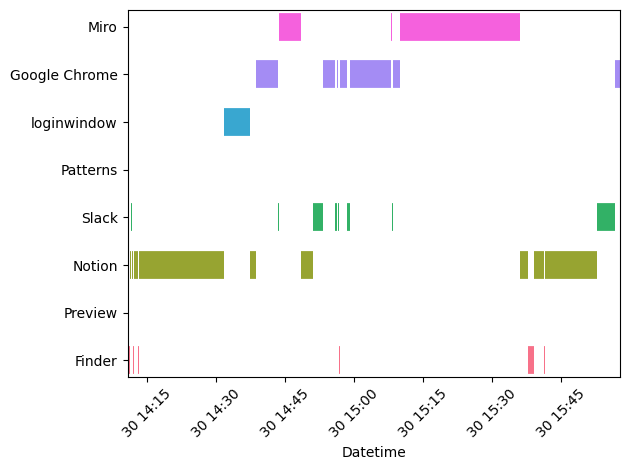

True
3.10.5 (v3.10.5:f377153967, Jun  6 2022, 12:36:10) [Clang 13.0.0 (clang-1300.0.29.30)]
Making request to OPENAI API...
{'urlCategoryArray': [{'url': 'Google Chrome -- Meet - Design sync', 'category': 'Communication & Collaboration'}, {'url': 'Weather --', 'category': 'News & Current Events'}, {'url': 'Google Chrome -- Participant list - Google Sheets', 'category': 'Professional Resources & Tools'}, {'url': 'https://eu.mixpanel.com/ -- Onboarding Funnel - Beams-Mac-Bar-Production / Mixpanel', 'category': 'Research & Information Gathering'}]}
Communication & Collaboration
News & Current Events
Professional Resources & Tools
Research & Information Gathering


/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
2023-08-31 18:23:48.404341: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


News
Social


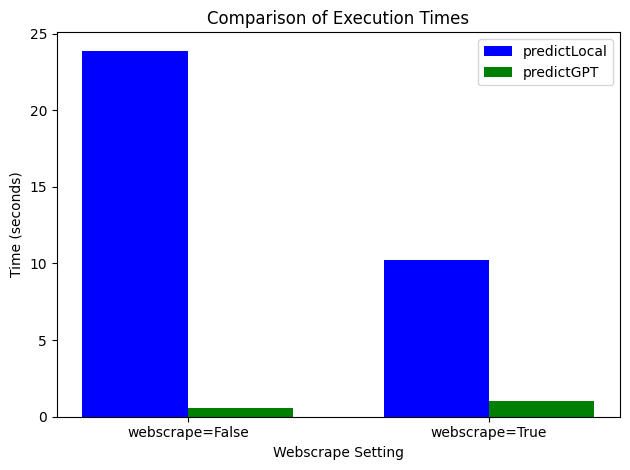

Social
News
Social
Social
Social
Social
Social
Educational
Social
Social
Professional
Social
Professional
Professional


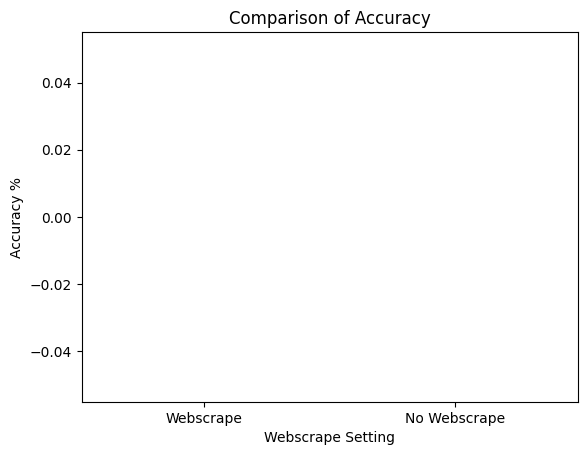

Missed Predictions:
-------------------------
Webscrape: 
https://nytimes.com/   as   Social
https://youtube.com/   as   Social
https://twitter.com/   as   Social
https://amazon.com/   as   Social
https://chat.openai.com/   as   Social
https://stackoverflow.com/   as   Professional
https://code.visualstudio.com/   as   Professional
..........
No Webscrape: 
https://nytimes.com/   as   News
https://youtube.com/   as   Social
https://twitter.com/   as   Social
https://amazon.com/   as   Educational
https://chat.openai.com/   as   Social
https://stackoverflow.com/   as   Social
https://code.visualstudio.com/   as   Professional


In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import bs4, requests

import pandas as pd
import numpy as np
import ipynb
import os
import seaborn as sns
from ipynb.fs.full.SurveyUpload import uploadSurvey
from ipynb.fs.full.DataUpload import getPatterns
import openai
import json
import time
import matplotlib.pyplot as plt
import re

from ipynb.fs.full.CategorizationFunctions import predictLocal
from ipynb.fs.full.CategorizationFunctions import predictGPT
from ipynb.fs.full.CategorizationFunctions import categorize



In [4]:
df = getPatterns()

In [5]:
df.head()

,createdAt,title,name,bundleIdentifier,url,source_file,event,properties,date,time,datetime,end_time,delta,base_url,category,user
0,7.018782e+08,,Finder,com.apple.finder,,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:10:42.150009033,2023-03-30 14:10:42.150009033,2023-03-30 14:10:50.292375000,0 days 00:00:08.142365967,<NA>,[Shopping],Monkey
1,7.018783e+08,,Preview,com.apple.Preview,,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:10:50.292375,2023-03-30 14:10:50.292375000,2023-03-30 14:10:55.191275879,0 days 00:00:04.898900879,<NA>,[Entertainment],Monkey
2,7.018783e+08,,Finder,com.apple.finder,,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:10:55.191275879,2023-03-30 14:10:55.191275879,2023-03-30 14:11:12.651991943,0 days 00:00:17.460716064,<NA>,[Shopping],Monkey
3,7.018783e+08,,Notion,notion.id,,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:11:12.651991943,2023-03-30 14:11:12.651991943,2023-03-30 14:11:24.028187988,0 days 00:00:11.376196045,<NA>,[Professional Resources & Tools],Monkey
4,7.018783e+08,,Slack,com.tinyspeck.slackmacgap,,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:11:24.028187988,2023-03-30 14:11:24.028187988,2023-03-30 14:11:26.361884033,0 days 00:00:02.333696045,<NA>,"[Communication & Collaboration, Communication ...",Monkey


In [6]:
categories = {
    'Professional Resources & Tools': set(),
    'Communication & Collaboration': set(), 
    'Research & Information Gathering': set(), 
    'News & Current Events': set(), 
    'Social Media & Networking': set(), 
    'Entertainment': set(), 
    'Shopping': set(), 
    'Financial & Administrative': set(), 
    'Personal Interest': set(),
    'Education & Development': set()
    }


In [7]:
def split_list(input_list, chunk_size=50):
    return [input_list[i:i+chunk_size] for i in range(0, len(input_list), chunk_size)]


In [8]:
set1 = set(zip(df['base_url'], df['title']))
set2 = set(zip(df['name'], df['title']))

# Take union of the two sets
need_categorization = list(set1 | set2)
print(len(need_categorization))
already_categorized = set()
tbc = split_list(need_categorization)
print(tbc)

6098
[[('https://drive.google.com/', 'Reporting – Google Drive'), ('https://linear.app/', 'BEA-66 Recognize calendar conflict when setting focus time duration'), ('https://demo.rouvia.com/', 'Booking #12 | Rouvia'), ('https://app.clickup.com/', 'Knowledge Sharing Sessions | 8. Knowledge Sharing | rouvia (List)'), ('https://www.youtube.com/', '(3) Una lezione molto soporifera | ASMR ITA | Geografia Italia • Regioni - YouTube'), ('https://mail.google.com/', 'Inbox (23) - jana@usebeams.com - usebeams.com Mail'), ('Google Chrome', 'Boost Your Productivity with beams: Success Stories from Can, Alexandra, and Max | beams'), ('Google Chrome', 'inovex-calendarsync / CalendarSync · GitLab'), ('https://get.adobe.com/', 'Adobe - Adobe\xa0Acrobat\xa0Reader\xa0DC herunterladen'), ('https://www.notion.so/', '(9+) Experiment Design'), ('https://www.ascendpartner.com/', "Advertisers | Pepperjam\\'s Ascend Affiliate Platform"), ('https://meet.google.com/', 'Meet - David and Jana Schellong'), ('Google C

- 920 total unique websites and app names
- Split into lists of ~50 each (19)
- 30 second delay between each batch
- 1 second delay between each individual categorization

(920 * 1) + (19 * 30) = 1490 seconds = ~25 minutes

Implies min runtime of at least 25 minutes

If the code stops partway through then just rerun it

In [9]:
print(len(need_categorization))

6098


In [ ]:
def getEmbedding(site):
    response = openai.Embedding.create(
        input=site,
        model="text-embedding-ada-002"
    )
    embeddings = response['data'][0]['embedding']

In [13]:
def newCategorization(to_be_categorized, already_categorized):
    start_total_time = time.time()
    for i, batch in enumerate(to_be_categorized):
        start_batch_time = time.time()
        mins, secs = divmod(start_batch_time-start_total_time, 60)
        print("Starting batch at " + str(mins) + "m " + str(round(secs)) + "s")
        
        if batch[-1] not in already_categorized:
            categoryList = categorize(batch)
            print(batch)
            print(categoryList['urlCategoryArray'])
            print("length batch: " + str(len(batch)))
            print("length categories: " + str(len(categoryList['urlCategoryArray'])))
            for idx, entry in enumerate(categoryList['urlCategoryArray']):
                site_title_to_add = tuple(entry["url"].split(" -- "))
                already_categorized.add(site_title_to_add)
                if entry['category'] in categories.keys():
                    categories[entry['category']].add(site_title_to_add)
                else: 
                    for cat in categories.keys():
                        if cat in entry['category']:
                            categories[cat].add(site_title_to_add)
                            break
                    #else just assign Personal Interest as default if output is not clear
                    categories["Personal Interest"].add(site_title_to_add)

        total_batch_time = time.time()-start_batch_time
        print("Categorized: " + str(len(already_categorized)) + " total sites.")
        print("Batch #: " + str(i) + " took " + str(total_batch_time) + " seconds to complete")
        if total_batch_time > 1:
            print("Waiting 10s before next batch ...")
            time.sleep(10)
        else:
            print("Last batch has already been categorized. Waiting only 0.1s before next batch ...")
            time.sleep(0.1)

    return (categories, already_categorized)

    

        

In [14]:
newCategorization(tbc, already_categorized)

Starting batch at 0.0m 0s
Making request to OPENAI API...
[('https://drive.google.com/', 'Reporting – Google Drive'), ('https://linear.app/', 'BEA-66 Recognize calendar conflict when setting focus time duration'), ('https://demo.rouvia.com/', 'Booking #12 | Rouvia'), ('https://app.clickup.com/', 'Knowledge Sharing Sessions | 8. Knowledge Sharing | rouvia (List)'), ('https://www.youtube.com/', '(3) Una lezione molto soporifera | ASMR ITA | Geografia Italia • Regioni - YouTube'), ('https://mail.google.com/', 'Inbox (23) - jana@usebeams.com - usebeams.com Mail'), ('Google Chrome', 'Boost Your Productivity with beams: Success Stories from Can, Alexandra, and Max | beams'), ('Google Chrome', 'inovex-calendarsync / CalendarSync · GitLab'), ('https://get.adobe.com/', 'Adobe - Adobe\xa0Acrobat\xa0Reader\xa0DC herunterladen'), ('https://www.notion.so/', '(9+) Experiment Design'), ('https://www.ascendpartner.com/', "Advertisers | Pepperjam\\'s Ascend Affiliate Platform"), ('https://meet.google.c

KeyboardInterrupt: 

In [35]:
def batch_categorize(set_to_be_categorized, already_categorized):
    for idx, site_tuple in enumerate(set_to_be_categorized):
        site, title = site_tuple
        if site_tuple not in already_categorized:
            #add site to already categorized set and remove it from set to be categorized
            #set_to_be_categorized.discard(site)
            already_categorized.add(site_tuple)

            #this is where the chatgpt prediction occurs (1 second delay added to prevent server overload):
            categorized = predictGPT(site, title=title)
            print(categorized)
            time.sleep(1.5)

            #add the predicted category to the dictionary
            if categorized in categories.keys():
                categories[categorized].add(site_tuple)
            else: 
                for cat in categories.keys():
                    if cat in categorized:
                        categories[cat].add(site_tuple)
                        break
                #else just assign Personal Interest as default if output is not clear
                categories["Personal Interest"].add(site_tuple)
    
    return (categories, already_categorized)
    

In [43]:
start_total_time = time.time()
for idx, batch in enumerate(tbc):
    start_batch_time = time.time()
    mins, secs = divmod(start_batch_time-start_total_time, 60)
    print("Starting batch at " + str(mins) + "m " + str(round(secs)) + "s")
    categories, already_categorized = batch_categorize(batch, already_categorized)
    total_batch_time = time.time()-start_batch_time
    print("Categorized: " + str(len(already_categorized)) + " total sites.")
    print("Batch #: " + str(idx) + " took " + str(total_batch_time) + " seconds to complete")
    if total_batch_time > 1:
        print("Waiting 30s before next batch ...")
        time.sleep(30)
    else:
        print("Last batch has already been categorized. Waiting only 0.1s before next batch ...")
        time.sleep(0.1)

Starting batch at 0.0m 0s
Categorized: 5918 total sites.
Batch #: 0 took 0.019223928451538086 seconds to complete
Last batch has already been categorized. Waiting only 0.1s before next batch ...
Starting batch at 0.0m 0s
Categorized: 5918 total sites.
Batch #: 1 took 0.01846599578857422 seconds to complete
Last batch has already been categorized. Waiting only 0.1s before next batch ...
Starting batch at 0.0m 0s
Categorized: 5918 total sites.
Batch #: 2 took 0.010320901870727539 seconds to complete
Last batch has already been categorized. Waiting only 0.1s before next batch ...
Starting batch at 0.0m 0s
Categorized: 5918 total sites.
Batch #: 3 took 0.015585660934448242 seconds to complete
Last batch has already been categorized. Waiting only 0.1s before next batch ...
Starting batch at 0.0m 0s
Categorized: 5918 total sites.
Batch #: 4 took 0.02141427993774414 seconds to complete
Last batch has already been categorized. Waiting only 0.1s before next batch ...
Starting batch at 0.0m 1s
C

In [13]:
print(categories)

{'Professional Resources & Tools': {('https://docs.google.com/', 'Sign-up (Responses) - Google Sheets'), ('GrandPerspective', ''), ('Snagit 2023', ''), ('https://mail.google.com/', 'Inbox (3) - raphaelfleckenstein1@gmail.com - Gmail'), ('https://mail.google.com/', 'beams - SaaS meta layer - follow-up - jana@usebeams.com - usebeams.com Mail'), ('Patterns', ''), ('https://auth.inovex.de/', 'Anmelden'), ('AltTab', ''), ('https://jira.inovex.de/', 'Google\xa0Meet – Bi-Weekly: Diversity'), ('https://idigit.onl/', 'Wie findet man die Google Place ID kostenlos und einfach heraus? » idigIT e.U.'), ('Safari', 'Stripe: Help & Support'), ('https://u3302489.ct.sendgrid.net/', 'Dash'), ('Google Chrome', 'FAQs'), ('Google Chrome', 'Seite bearbeiten „Pressebereich“ ‹ inovex GmbH — WordPress'), ('Google Chrome', 'base case capital - Crunchbase Investor Profile & Investments'), ('Google Chrome', 'Contact us at HearUSA'), ('Safari', 'Installing Slack'), ('Google Chrome', 'Personio · Recruiting'), ('http

In [15]:
print(len(already_categorized))

533


In [ ]:
class ExtendedEncoder(json.JSONEncoder):
    def default(self, obj):
        # Convert pandas NAType objects to None
        if isinstance(obj, pd.NA.__class__):
            return None
        # Let the base class handle any other types
        return super(ExtendedEncoder, self).default(obj)

def writeJSON(dictionary, file_name):
    # Convert sets to lists within the dictionary
    serialized_dict = {key: list(value) if isinstance(value, set) else value for key, value in dictionary.items()}
    
    with open(file_name, 'w') as json_file:
        json.dump(serialized_dict, json_file, cls=ExtendedEncoder)

In [48]:
def readJSON(file_name):
    with open(file_name, 'r') as json_file:
        loaded_data = json.load(json_file)
        return loaded_data

In [46]:
writeJSON(categories, 'categoriesNew.json')

In [50]:
cats = readJSON('categoriesNew.json')
print(cats)

{'Professional Resources & Tools': [['Google Chrome', 'Meet - Design sync'], ['Google Chrome', 'Participant list - Google Sheets'], ['https://eu.mixpanel.com/', 'Onboarding Funnel - Beams-Mac-Bar-Production / Mixpanel'], ['https://www.dropbox.com/', 'dropbox.com'], ['https://rouvia.personio.de/', 'Dashboard'], ['https://dndy.de/', 'DNDY Data and Design GmbH'], ['https://app.clickup.com/', 'Frontend | rouvia (List)'], ['https://eu.mixpanel.com/', 'Favourite event per user - Beams-Mac-Bar-Production / Mixpanel'], ['https://schulung.datenschutzkanzlei.de/', 'Datenschutz für Beschäftigte | Datenschutzkanzlei Academy'], ['https://support.zendesk.com/', 'Understanding, installing, and configuring the Slack for Zendesk Support integration – Zendesk help'], ['https://www.figma.com/', 'Rouvia - Calendar - Week of May 1, 2023'], ['Google Chrome', 'Sri Lanka im Oktober'], ['https://apps.apple.com/', 'InstaView on the Mac\xa0App\xa0Store'], ['https://www.notion.so/', '(9+) Weekly Planning & Sync']

In [ ]:

def chat_completion():
    print("Received request for chat completion")
    print("Calling OpenAI API")

    example_function_1 = {
        'name': "exampleFunction1",
        'description': "Use this function to do x, y, z",
        'parameters': {
            'type': "object",
            'properties': {
                'objectName': {
                    'type': "string",
                    'description': "Describing the output that you would like from the function"
                }
            }
        }
    }

    example_function_2 = {
        'name': "exampleFunction2",
        'description': "Another explanation.",
        'parameters': {
            'type': "object",
            'properties': {
                'someKindOfArrayOutput': {
                    'type': "array",
                    'description': "Describing array.",
                    'items': {
                        'type': "object",
                        'description': "Custom data type",
                        'properties': {
                            'property1': {
                                'type':"string",
                                'description': "this could be url",
                            },
                            'property2': {
                                'type': "string",
                                'description': "this could be category (but you would turn this into an object instead of string)"
                            },
                            'property3': {
                                'type':"integer",
                                'description': "Another property"
                            }
                        },
                        'required': ["property1", "property2", "property3"]
                    }
                },
                'required': ["someKindOfArrayOutput"]
            }
        }
    }

    try:
        result1 = openai.create_chat_completion(
            model="gpt-3.5-turbo-0613",
            messages=[
                {'role': "system", 'content': "Categorize these urls into the given categories: category1, category2, etc."},
            ],
            functions=[example_function_1, example_function_2],
            function_call={
                'name': "categorizeWords"
            }
        )
        return result1
    except Exception as e:
        return str(e), 500


## Final version concept:

Pre-categorized dictionary of 6000 sites and titles (by gpt) forms the basis of future categorization, which occurs in a few steps:
1. If the site and title already exist in the dictionary, use the category
2. If the site exists, but the title doesn't, and there are more than 3 entries in the dictionary under that site, use a pretrained ML classification model that takes advantage of NLP
3. If neither of the above conditions hold, call the gpt classification function and add the newly classified website to the dictionary

The classification can be done in one (or both) of the following ways:

### Option 1: Text Classification using BERT/DistilBERT (or a simpler ML algorithm like GBT or a neural net):
1. Dataset Preparation:
Gather a labeled dataset with website titles (or content) and their corresponding categories.
Split the dataset into training, validation, and testing subsets.
2. Preprocessing:
Tokenize the website titles using a tokenizer suitable for BERT/DistilBERT. For instance, the BertTokenizer from the Hugging Face's transformers library.
3. Model Setup:
Use the transformers library to load a pre-trained BERT/DistilBERT model. E.g., BertForSequenceClassification or DistilBertForSequenceClassification.
Specify the number of classification labels, which should match the number of categories in your dataset.
4. Training:
Define a loss function (e.g., cross-entropy for classification) and an optimizer (like Adam).
Train the model on your training dataset, and validate its performance on the validation dataset. Use the tokenized website titles as input and the categories as targets.
Save the model weights once training is complete.
5. Evaluation and Prediction:
Evaluate the model's performance on the test dataset.
For new website titles, tokenize them and pass them through the trained model to get category predictions.

### Option 2: Website Classification using the Shodan API:
1. API Setup:
Sign up on Shodan and get your API key.
Install the Shodan library: pip install shodan.
2. Fetch Data from Shodan:

import shodan 

api = shodan.Shodan(YOUR_API_KEY)

result = api.search('your_website_domain')

3. Extract Information:
The returned result will be a dictionary containing information about the searched domain.
Explore the result to understand the type of information provided. For our case, focus on metadata that can give clues about the website's category.
4. Category Mapping:
Based on the information from Shodan, design a heuristic or rule-based system to classify websites.
For instance, if Shodan returns that a site is running e-commerce software, classify it as 'Shopping'.
Implement these rules in your code to automate categorization.
5. Handling Unclassified Sites:
Not all websites might be categorized using Shodan's data alone. For these, either:
Set them to a default "Unclassified" category.
Use another method, like BERT/DistilBERT, to categorize them.
6. Continuous Update:
Keep updating your rules and heuristics as you get more data and as Shodan updates its database.



In [ ]:
####

If you want to use gpt to create its own categories, run the code below:

(NOT RECOMMENDED -> PREFERRED STRATEGY IS A PREDETERMINED LIST OF CATEGORIES)

In [79]:
def classifyList(sites):
    gptOutput = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
            {"role": "system", "content": "You are website and app classification assistant."},
            {"role": "user", "content": "This is a list of apps and websites: [" + sites + "]. \
            Make a python dictionary with the classification categories (at most 10 of them) as the keys \
             and the websites/apps as the values. Don't include any explanations in your responses. \
            "},
        ]
    )
    return gptOutput

In [80]:
gptOutput = classifyList(total)
categories = gptOutput["choices"][0]["message"]["content"]
categoryDict = json.loads(categories)
print(categoryDict.keys())